In [1]:
import tensorflow as tf
from tensorflow.python import keras as keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, Flatten, Dense
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.utils import np_utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm

In [2]:
# 取得圖片大小

IMG_WIDTH=256
IMG_HEIGHT=256

In [3]:
def preprocess_image(img):
    target_size = (IMG_HEIGHT, IMG_WIDTH, img.shape[2])
    padded_img = np.zeros(target_size, dtype=np.uint8)
    padded_img[:min(IMG_HEIGHT,img.shape[0]), :min(IMG_WIDTH,img.shape[1]), 0] = img[:min(IMG_HEIGHT,img.shape[0]), :min(IMG_WIDTH,img.shape[1]), 0]
    return padded_img

In [4]:
#載入資料

dataTrain=[]
dataLabel=[]
maxDataAmount = 2048
currentDataCount = 0

# 載入未被隱寫過的圖片
file_list=os.listdir('../imageDatabase/outputImages/96/')
for file in tqdm(file_list):
    if currentDataCount > maxDataAmount:
        break
    else:
        currentDataCount+=1
    
    if file.endswith('.png') or file.endswith('.jpg'):
        img=cv2.imread('../imageDatabase/outputImages/96/'+file)
        img = img & 0x0001
        img *= 255
        img = preprocess_image(img)
        dataTrain.append(img)
        if file[0]=='_':
            dataLabel.append(1)
        else :
            dataLabel.append(0)

# print('dataTrain len:',len(dataTrain))

currentDataCount = 0
# 載入已被隱寫過的圖片
file_list=os.listdir('./outputImages')
for file in tqdm(file_list):
    if currentDataCount > maxDataAmount :
        break
    else :
        currentDataCount+=1
    
    if file.endswith('.png') or file.endswith('.jpg'):
        img=cv2.imread('./outputImages/'+file)
        img = img & 0x0001
        img *= 255
        img = preprocess_image(img)
        dataTrain.append(img)
        if file[0]=='_':
            dataLabel.append(1)
        else :
            dataLabel.append(0)

# print('dataTrain len:',len(dataTrain))


# 打亂資料
indices = np.random.permutation(len(dataTrain))
dataTrain = [dataTrain[i] for i in indices]
dataLabel = [dataLabel[i] for i in indices]
print("data train:", len(dataTrain), ", label:", len(dataLabel))
# print(dataLabel)

 20%|███████████████                                                            | 2049/10201 [00:01<00:07, 1031.20it/s]

data train: 4097 , label: 4097


In [5]:
# 將資料分成訓練集（80%）和測試集（20%）
split_ratio = 0.8
split_index = int(len(dataTrain) * split_ratio)

x_train, y_train = dataTrain[:split_index], dataLabel[:split_index]
x_test, y_test = dataTrain[split_index:], dataLabel[split_index:]

# 將資料轉換為NumPy數組，並指定數據類型為uint8
x_train = np.array(x_train, dtype=np.uint8)
y_train = np.array(y_train, dtype=np.uint8)
x_test = np.array(x_test, dtype=np.uint8)
y_test = np.array(y_test, dtype=np.uint8)



In [6]:
#檢視資料

print(x_train.shape) #代表訓練資料集有60000張圖片
print(y_train.shape) #代表訓練資料集有60000個label
print(x_test.shape)#代表驗證資料集有10000張圖片
print(y_test.shape) #代表驗證資料集有10000個label
# plt.imshow(x_train[0],cmap="gray") #用圖片表示x_train的第一筆資料
# plt.show()
print("y_train[0]: ",y_train[0])

(3277, 256, 256, 3)
(3277,)
(820, 256, 256, 3)
(820,)
y_train[0]:  0


In [7]:
#進行資料預處理

x_train_4d = x_train.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3).astype("float32") # 將圖像資料轉為浮點數
x_test_4d = x_test.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3).astype("float32") # 將測試圖像資料轉為浮點數

x_train_normalize = x_train_4d / 255.0 # 標準化，將像素值縮放到 0-1 的範圍
x_test_normalize = x_test_4d / 255.0 # 標準化，將像素值縮放到 0-1 的範圍

y_train_onehot = np_utils.to_categorical(y_train,2) # 將訓練標籤轉換為 one-hot 編碼
y_test_onehot = np_utils.to_categorical(y_test,2) # 將測試標籤轉換為 one-hot 編碼

# print("before: ", y_train[2])
# print("after(one-hot): ", train_Label[2])
print("x train 4D shape:", x_train_4d.shape)
print("y_train_onehot:", y_train_onehot.shape)



x train 4D shape: (3277, 256, 256, 3)
y_train_onehot: (3277, 2)


In [8]:
#建立模型

model = keras.Sequential()
# 卷積層
model.add(Conv2D(filters=16, kernel_size=(7, 7), padding='same', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3, 3), padding='same', activation='relu'))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))

# 池化層
model.add(AveragePooling2D(pool_size=(2, 2)))

# 扁平化 連接MLP
#Dense為一種神經網路層，會將上一層與下一層的神經元全部連接
model.add(Flatten())  
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax')) # output




In [9]:
#查看模型資訊

model.summary()

#Layer(type): 標示每層的名稱跟種類

#Output: 暫時未知

#Shape: 該層的維度資料

#Param: 該層參數的數量，計算方法為: 上一層神經元數量*本層神經元數量+本層神經元數量
       #例如: 2570(dense_3的參數數量)=256(上一層的神經元數量)*10(本層--即輸出層的神經元數量)+10(本層--即輸出層的神經元數量)

#Total params: 總共的Param數量，越大代表模型越複雜，所需訓練時間愈久

#Trainable params: 模型中需要在訓練過程中學習的參數

#Non-trainable params: 模型中不需要在訓練過程中學習的參數


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      2368      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 32)      4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 256, 256, 32)      9

In [10]:
#編譯模型

model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
#設定損失函數為categorical_crossentropy，最佳化方法為adam，評估模型方式為accuracy(準確率)

In [11]:
#訓練模型
print(x_train_normalize.shape)
print(y_train_onehot.shape)

train_history=model.fit(x=x_train_normalize, y=y_train_onehot, epochs=20, batch_size=16, verbose=2,validation_split=0.1 )
#將預處理過的資料當作訓練參數傳入
# batch_size(每一批次的資料數)為128
# epochs(訓練週期)為10，
# validation_split(驗證資料比例)為0.2
# verbose = 2表示會print每一個epochs的即時進度 類似tqdm

#loss: 使用訓練資料的誤差

#accuracy: 使用訓練資料的準確率

#val_loss: 使用驗證資料的誤差

#val_accuracy: 使用驗證資料的準確率

(3277, 256, 256, 3)
(3277, 2)
Epoch 1/20
185/185 - 53s - loss: 0.3688 - accuracy: 0.8420 - val_loss: 0.3454 - val_accuracy: 0.9482
Epoch 2/20
185/185 - 53s - loss: 0.1551 - accuracy: 0.9607 - val_loss: 0.1778 - val_accuracy: 0.9573
Epoch 3/20
185/185 - 54s - loss: 0.0644 - accuracy: 0.9915 - val_loss: 0.1369 - val_accuracy: 0.9848
Epoch 4/20
185/185 - 55s - loss: 0.0541 - accuracy: 0.9898 - val_loss: 0.1284 - val_accuracy: 0.9848
Epoch 5/20
185/185 - 54s - loss: 0.2650 - accuracy: 0.9603 - val_loss: 0.1247 - val_accuracy: 0.9543
Epoch 6/20
185/185 - 54s - loss: 0.1151 - accuracy: 0.9715 - val_loss: 0.1397 - val_accuracy: 0.9848
Epoch 7/20
185/185 - 53s - loss: 0.0733 - accuracy: 0.9908 - val_loss: 0.0845 - val_accuracy: 0.9848
Epoch 8/20
185/185 - 55s - loss: 0.0477 - accuracy: 0.9936 - val_loss: 0.0990 - val_accuracy: 0.9817
Epoch 9/20
185/185 - 54s - loss: 0.0351 - accuracy: 0.9939 - val_loss: 0.0840 - val_accuracy: 0.9848
Epoch 10/20
185/185 - 53s - loss: 0.0306 - accuracy: 0.9949 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


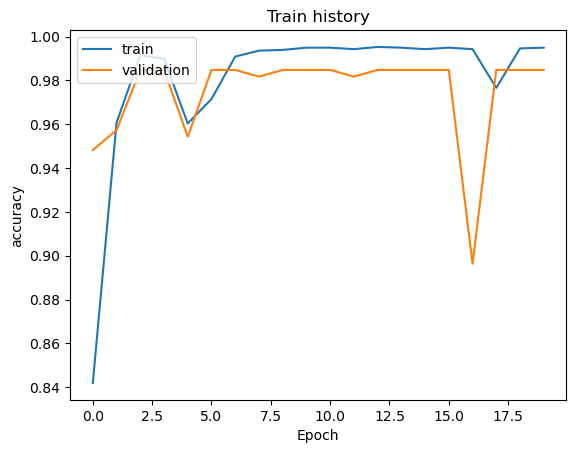

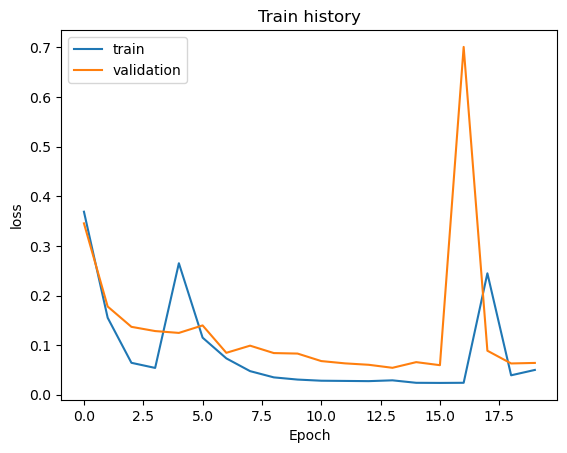

In [12]:
#使用matplotlib將train_history的資料繪製成圖表

def Show_Train_History(train_history,train,validation):
    plt.plot(train_history.history[train]) #設定資料來源
    plt.plot(train_history.history[validation]) #設定資料來源
    plt.title('Train history') #設定圖表標題 
    plt.xlabel('Epoch') #設定x軸欲顯示的文字
    plt.ylabel(train) #設定y軸欲顯示的文字
    plt.legend(['train','validation'],loc='upper left') #設定左上角的指引
    plt.show()
    
print(train_history.history.keys())
Show_Train_History(train_history,'accuracy','val_accuracy') #訓練資料集與驗證資料集的準確率比較
Show_Train_History(train_history,'loss','val_loss') #訓練資料集與驗證資料集的誤差比較

In [13]:
#驗證模型

model.evaluate(x_test_normalize, y_test_onehot) #將驗證資料集當參數傳入以進行模型的驗證

26/26 [==============================] - 3s 132ms/step - loss: 0.0841 - accuracy: 0.9854


[0.08408208936452866, 0.9853658676147461]

In [14]:
#進行預測

predictions = model.predict(x_test[:])  # 取測試資料集的前十筆進行預測
predictions = np.argmax(predictions, axis=1)  # 取得每個預測的最大值的索引
print("predition: ",predictions)
for i in range(len(predictions)):
    # plt.imshow(x_test[i],cmap="gray") #使用matplotlib畫圖
    # plt.show()
    
    print("預測值: ", predictions[i], "實際值: ", y_test[i])

predition:  [0 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0
 1 0 1 0 0 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 0 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1
 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1
 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1 1 1 0 1 1
 0 1 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 1 1 1 0 1
 0 1 0 1 1 0 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0
 1 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 0
 0 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0
 1 0 0 0 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0
 1 0 0 0 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 1
 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0
 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1
 1 1 1 1 1 0 

In [15]:
#觀察混淆矩陣(confusion matrix)
  
def Precision(confusion_Matrix,column):
    Size=len(confusion_Matrix[0])
    Sum=0
    for i in range(Size):
        Sum+=confusion_Matrix[i][column]
    return confusion_Matrix[column][column]/Sum

def Recall(confusion_Matrix,row):
    Size=len(confusion_Matrix[0])
    Sum=0
    for i in range(Size):
        Sum+=confusion_Matrix[row][i]
    return confusion_Matrix[row][row]/Sum

print(y_test.shape)
print(predictions.shape)

confusion_Matrix=pd.crosstab(y_test,predictions,rownames=['label'],colnames=['predict']) #使用pandas內建功能來繪製混淆矩陣
#pd.crosstab(row的資料來源,column的資料來源,row名稱,column名稱)

print(confusion_Matrix) #印出confusion_Matrix
# print("\n當程式預測結果是0時，其正確率(precision)為: ",Precision(confusion_Matrix,0)) #計算precision(精確度)
# print("在所有的0中，程式能正確找出的比率(Recall)為: ",Recall(confusion_Matrix,0)) #計算Recall(召回率)


(820,)
(820,)
predict    0    1
label            
0        403    7
1          6  404


In [16]:
model.save('./LSB_QR_model.h5')